# Analysing titanic data and predicting Survivors based on Passenger class, Sex, Fare and Embarked location


### This is an attempt to participate Kaggle's Machine Learning Prediction compitition (https://www.kaggle.com/c/titanic/data)

In [50]:
# import dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Load dataset
titanic_df = pd.read_csv('data/train.csv')

In [3]:
# Set default figure size
sns.set(rc={'figure.figsize':(12,8)})

In [4]:
# QUick look at the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# total num of passengers 
print(f'There are {len(titanic_df)} total passengers in this training dataset')

There are 891 total passengers in this training dataset


# Data Cleanup

In [6]:
# Looking at column types and count
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
#Check for null values in each column
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

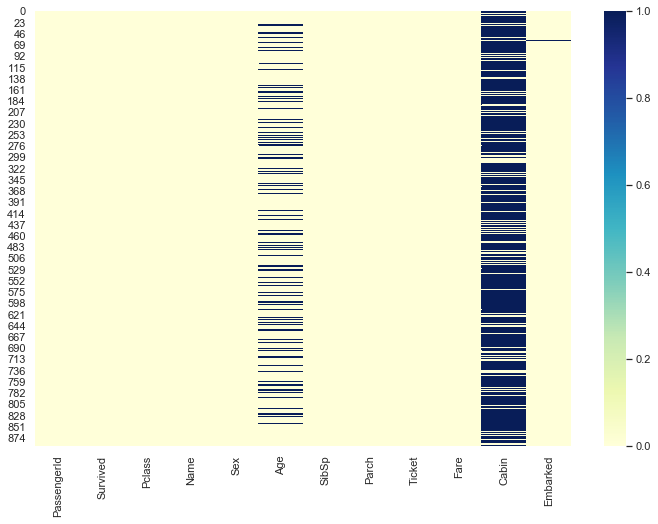

In [8]:
# Heatmap of null column values to get a better idea. Dark blue stands for null, 
# and off white means no null value ofr the respective column for each point.
sns.heatmap(titanic_df.isnull(),cmap="YlGnBu")

## We can see that about 20% of Age and majority of Cabin calues are null. 2 null values  for Embarked column also.

In [18]:
# Drop Cabin column
titanic_df.drop('Cabin', axis=1, inplace=True)

In [20]:
# Drop nulls from the dataframe
titanic_df.dropna(inplace=True)

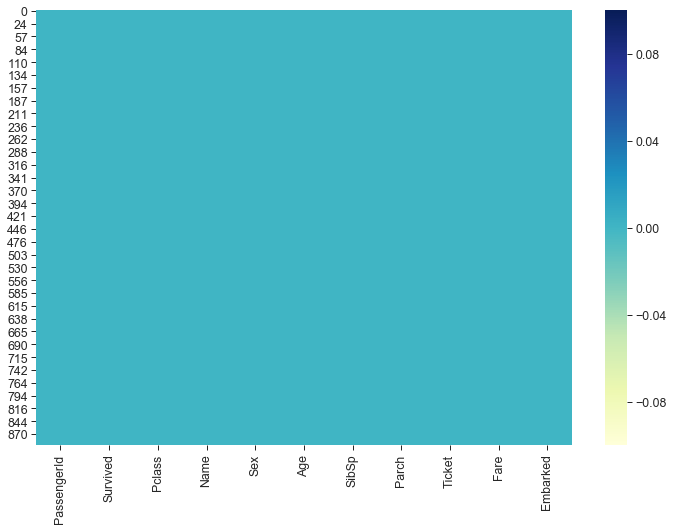

In [21]:
# Verifying that we dont have any more nulls. 
# Notice we dont see any black bars on the heatmap so all nulls have been dropped. - 

sns.heatmap(titanic_df.isnull(),cmap="YlGnBu")

# Data Analysis

## How many survivals for Male and Female

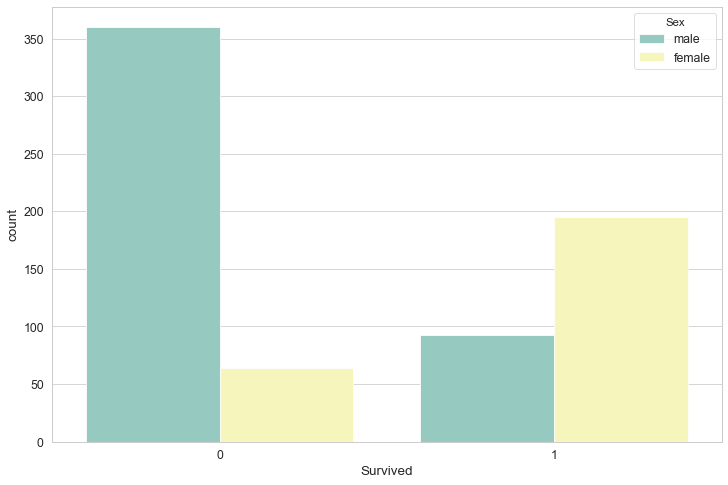

In [22]:
sns.set_style("whitegrid") 
sns.countplot(x="Survived", hue="Sex", data=titanic_df, palette="Set3")

### Most passengers who did not survive were Male

# How many survivals by passenger class?

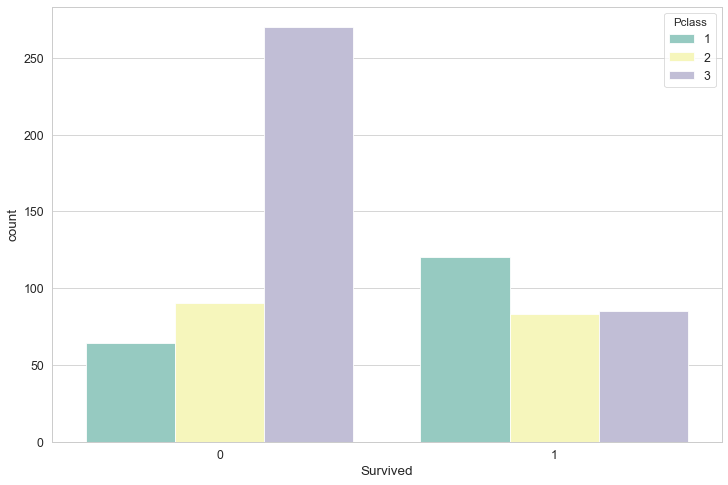

In [23]:
sns.countplot(x="Survived", hue="Pclass", data=titanic_df, palette="Set3")

### Most Passengers who did not survive belonged to Class 3 i.e the lowest class. Most people who survived belonged to Class 1, then Class 3 and then Class 2.

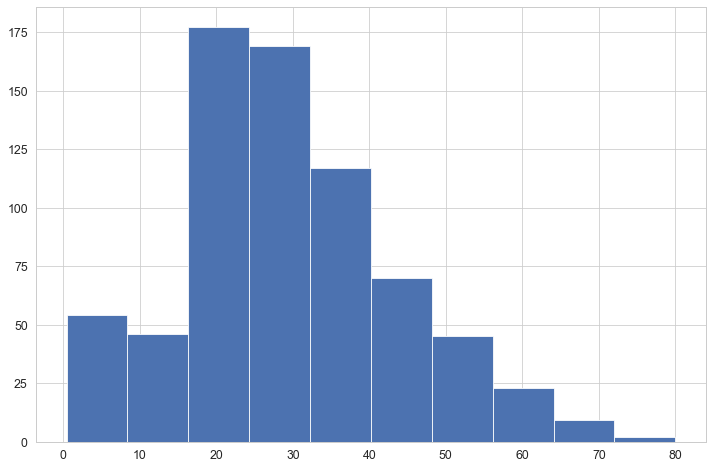

In [24]:
# What was the age distribution on the titanic
titanic_df['Age'].hist()

### As we can see, the titanic was populated by more younger people of age < 30. Which means lots of children and young adults.

## What were the ages of the survivors? What was the age distribution on the titanic

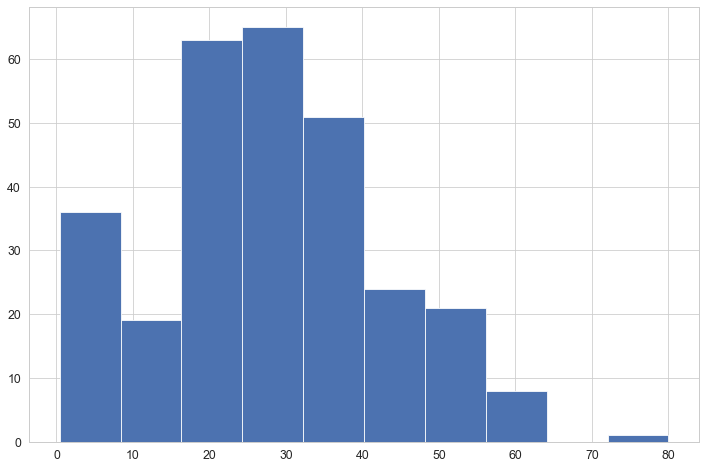

In [25]:
titanic_df[titanic_df['Survived'] == 1]['Age'].hist()

### Ages of 20-40 were more likely to survive, followed by Ages below 5. We would be inclined to think that children were more likelt to survive but Ages 10-20 have a lower number. We need to ask ourself if that is because there were a low number of population for ages 10-20. 
#### (There were close to 40 passengers from ages 10-20 and close to 20 survived)

## Analysing the fare distribution. How many people paid what sums of fare on the ship?

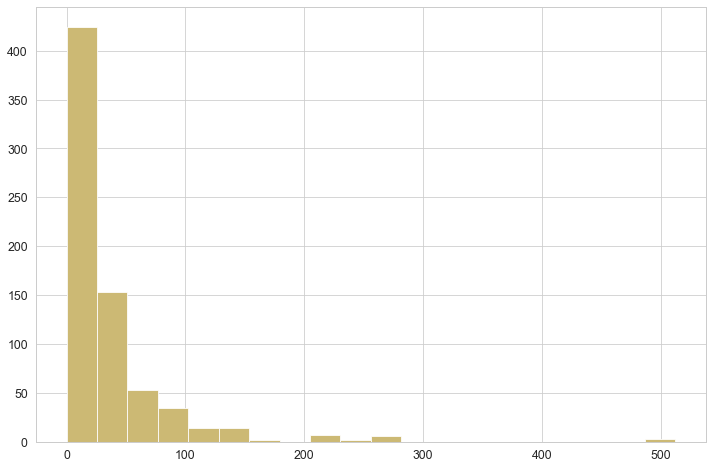

In [26]:
titanic_df['Fare'].hist(bins=20,color='y')

## What were the Fares of the survivors?

### Fare distribution on the titanic below - 


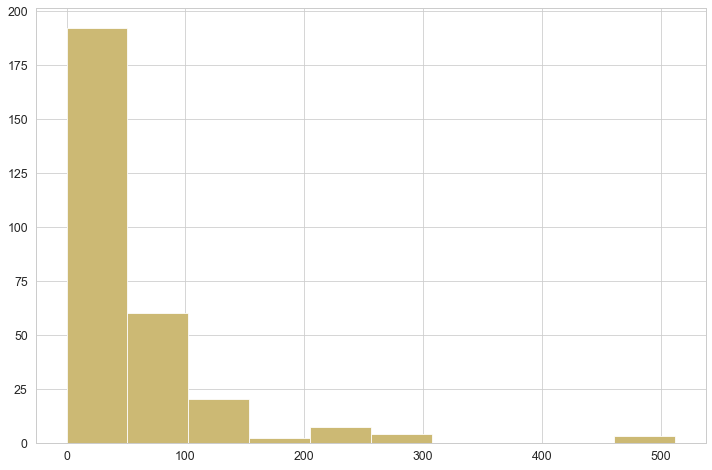

In [27]:
titanic_df[titanic_df['Survived'] == 1]['Fare'].hist(color='y')

# Analysing how many survived from the three embarking stations

### S - Southamption
### C - Cherbourg
### Q - Queenstown

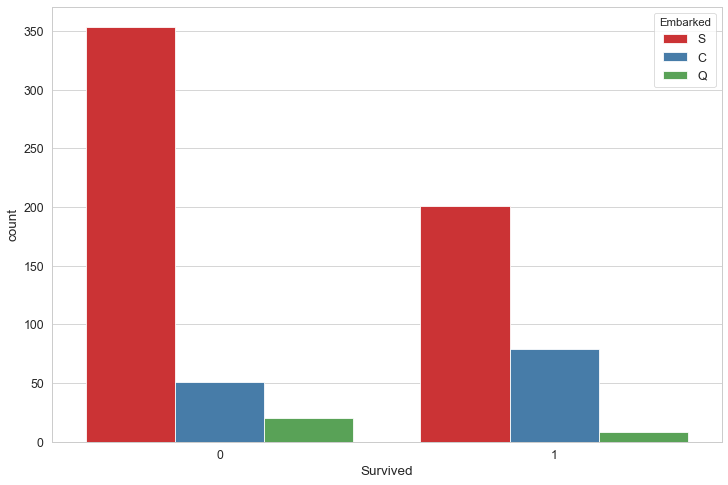

In [28]:
sns.countplot(x="Survived", hue="Embarked", data=titanic_df, palette="Set1")

### Most people who survived were from Southamption, but most people who did not survive also boarded from Southamption. Its safe to say the majority of the ship came from Southamption. 

## How do the Age values match with different passenger class

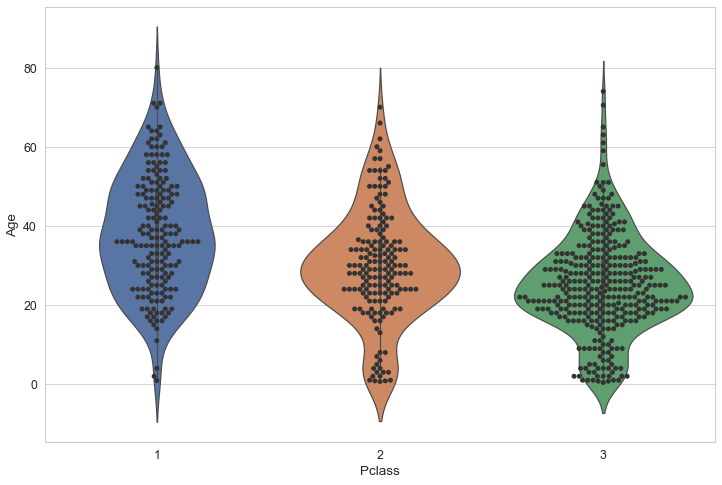

In [29]:
sns.violinplot(x='Pclass',y="Age",data=titanic_df)
sns.swarmplot(x='Pclass',y="Age",data=titanic_df,color='0.2')


### The mean ages for class 1 are higher than class 2, which is higher than class 3. This is intuitive becasue richer people tend to be of older age. Class 1 fare is the most expensive so has a higher mean age.

## Putting it together, We can plot for survived/Not Survived for Males/Females by Age Group and Fare paid for the ship.

#### 0 - Not Survived
#### 1 - Survived

### Red circles are Male while Blue circle markers are Female

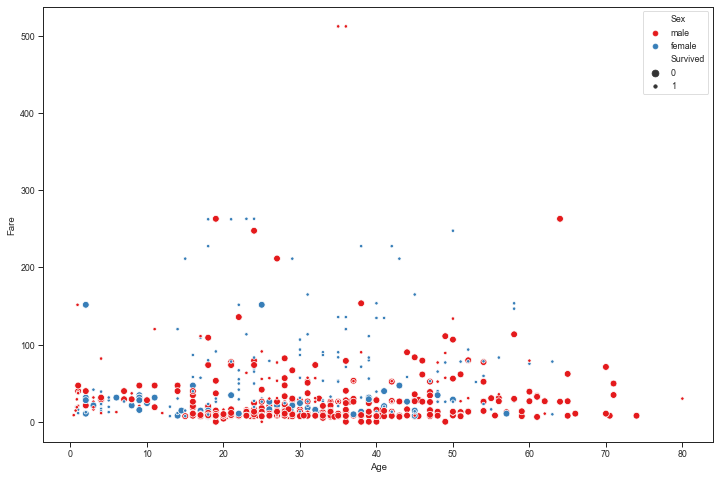

In [33]:
sns.scatterplot(x="Age", y="Fare",
                      hue="Sex", data=titanic_df,palette="Set1", size="Survived")
sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
sns.set_context("paper", font_scale=1.4)

# Preparing data for Logistic Regression

### We need to convert string values into binary (0 or 1) values

In [34]:
# Converting the Embarked column into a numerical binary value for Q,S and C. If both Q and C are 0, 
# then the value would automatically be C

embarked = pd.get_dummies(titanic_df['Embarked'], drop_first='True')

In [35]:
embarked.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [36]:
# Converting the P assenger Class column into a numerical binary value for 1,2,3. If both 2 and 3 are 0, 
# then the value would automatically be class 1

pcl = pd.get_dummies(titanic_df['Pclass'], drop_first='True')
pcl.head()

,2,3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [37]:
# Converting Sec column to a binary. If Male = 0, then the value would be a female automatically
sex = pd.get_dummies(titanic_df['Sex'], drop_first='True')
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [40]:
# Combining the above dataframe to our titanic dataframe
titanic_df = pd.concat([titanic_df, embarked, pcl, sex], axis=1)

In [41]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Q,S,2,3,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,1,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1,0,1,1


In [45]:
df_binary = titanic_df[["Survived","SibSp","Parch","Fare","male","Q","S",2,3,"male"]]

In [46]:
# Final dataset for Regression
df_binary.head()

,Survived,SibSp,Parch,Fare,male,Q,S,2,3,male
0,0,1,0,7.2500,1,0,1,0,1,1
1,1,1,0,71.2833,0,0,0,0,0,0
2,1,0,0,7.9250,0,0,1,0,1,0
3,1,1,0,53.1000,0,0,1,0,0,0
4,0,0,0,8.0500,1,0,1,0,1,1


# Logistic Regression

# Performing Machine Learning on the dataset prepared - 

In [53]:
# Assigning dependant and independant variables 

# Survived column is our dependant variable. We are trying to predict this variable
y = df_binary['Survived']

# The other columns are out independant variables. Hence we will drop Survived column from the dataframe
X = df_binary.drop('Survived', axis = 1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [57]:
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
 classifier.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.7978910369068541
Testing Data Score: 0.7482517482517482


In [60]:
# Predict
predictions = classifier.predict(X_test)
predictions

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

In [61]:
# Comparison of our prediction with actual result
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

,Prediction,Actual
689,1,1
279,1,1
508,0,0
9,1,1
496,1,1
150,0,0
474,1,0
469,1,1
794,0,0
864,0,0


In [65]:
from sklearn.metrics import classification_report, accuracy_score

In [64]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        87
           1       0.67      0.70      0.68        56

    accuracy                           0.75       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.75      0.75      0.75       143



## Accuracy of our model

In [66]:
accuracy_score(predictions,y_test)

0.7482517482517482